In [ ]:
install.packages("rcompanion")
install.packages("effsize")
library(rcompanion)
library(tidyverse)
library(dplyr)
library(effsize)
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘rootSolve’, ‘e1071’, ‘lmom’, ‘TH.data’, ‘sandwich’, ‘mvtnorm’, ‘expm’, ‘Exact’, ‘gld’, ‘libcoin’, ‘matrixStats’, ‘modeltools’, ‘multcomp’, ‘zoo’, ‘DescTools’, ‘multcompView’, ‘plyr’, ‘coin’, ‘lmtest’, ‘nortest’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:

directory <- "sample_data/user_testing"

file_list <- list.files(path = directory, pattern = "*.csv", full.names = TRUE)

all_data <- do.call(rbind, lapply(file_list, function(file) {
  read.csv(file) %>%
    mutate(SourceFile = basename(file))
}))

file_list <- list.files(path = directory, pattern = "*.csv", full.names = TRUE)
counter <- length(file_list)
counter

[1] 35

In [ ]:
all_data <- do.call(rbind, lapply(file_list, function(file) {
  read.csv(file) %>%
    mutate(SourceFile = basename(file))
}))

# Filter and process completion data
completion_data <- all_data %>%
  filter(suppressWarnings(is.na(as.numeric(Timestamp))) | (Event == "Object Selected" & SelectionResult == "Correct")) %>%
  mutate(NavigationMethod = case_when(
    Timestamp == "2D Map" ~ "2D Map",
    Timestamp == "3D Map" ~ "3D Map",
    Timestamp == "3D Interactive Map" ~ "3D Interactive Map",
    TRUE ~ NA_character_
  )) %>%
  tidyr::fill(NavigationMethod, .direction = "down")

# completion_data

In [ ]:
maps <- c("2D Map", "3D Map", "3D Interactive Map")

output_files <- list(
  "2D Map" = "2D_Map_Times.csv",
  "3D Map" = "3D_Map_Times.csv",
  "3D Interactive Map" = "3D_Interactive_Map_Times.csv"
)

for (map in maps) {
  write.table(
    data.frame(User = character(), TimeTakenSeconds = character()),
    file = output_files[[map]],
    sep = ",", row.names = FALSE, col.names = TRUE
  )
}


In [ ]:
# Process data for each user and map
for (user_index in 1:counter) {
  user_data <- completion_data %>%
    filter(SourceFile == basename(file_list[user_index]))

  user_id <- tools::file_path_sans_ext(basename(file_list[user_index]))

  # Process each navigation method
  for (map in maps) {
    method_data <- user_data %>%
      filter(NavigationMethod == map & Event == "Object Selected" & SelectionResult == "Correct")

    correct_time <- if (nrow(method_data) > 0) {
      as.numeric(method_data$Timestamp[1])
    } else {
      NA
    }

    new_data <- data.frame(
      User = paste0(user_id),
      TimeTaken = ifelse(is.na(correct_time), paste0(180), paste0(correct_time))
    )

    write.table(
      new_data,
      file = output_files[[map]],
      sep = ",", row.names = FALSE, col.names = !file.exists(output_files[[map]]),
      append = TRUE, quote = FALSE
    )
  }
}


This script calculates the average task completion time for each navigation method by reading individual data files for the methods (2D Map, 3D Map, and 3D Interactive Map).

In [ ]:
method_averages <- list()

# Loop through each navigation method
for (map in maps) {
  file_path <- output_files[[map]]

  if (file.exists(file_path)) {
    method_data <- read.csv(file_path)

    method_data$TimeTakenSeconds <- as.numeric(method_data$TimeTakenSeconds)

    average_time <- mean(method_data$TimeTakenSeconds, na.rm = TRUE)

    method_averages[[map]] <- average_time

    cat(paste("Average completion time for", map, ":", average_time, "seconds\n"))
  } else {
    cat(paste("File not found for", map, "\n"))
  }
}

Average completion time for 2D Map : 101.110285714286 seconds
Average completion time for 3D Map : 86.772 seconds
Average completion time for 3D Interactive Map : 57.2528571428571 seconds


These results reveal that the 3D Interactive Map is the fastest method, followed by the 3D Map, with the 2D Map being the slowest. This comparison provides a clear indication of the efficiency of each navigation method.

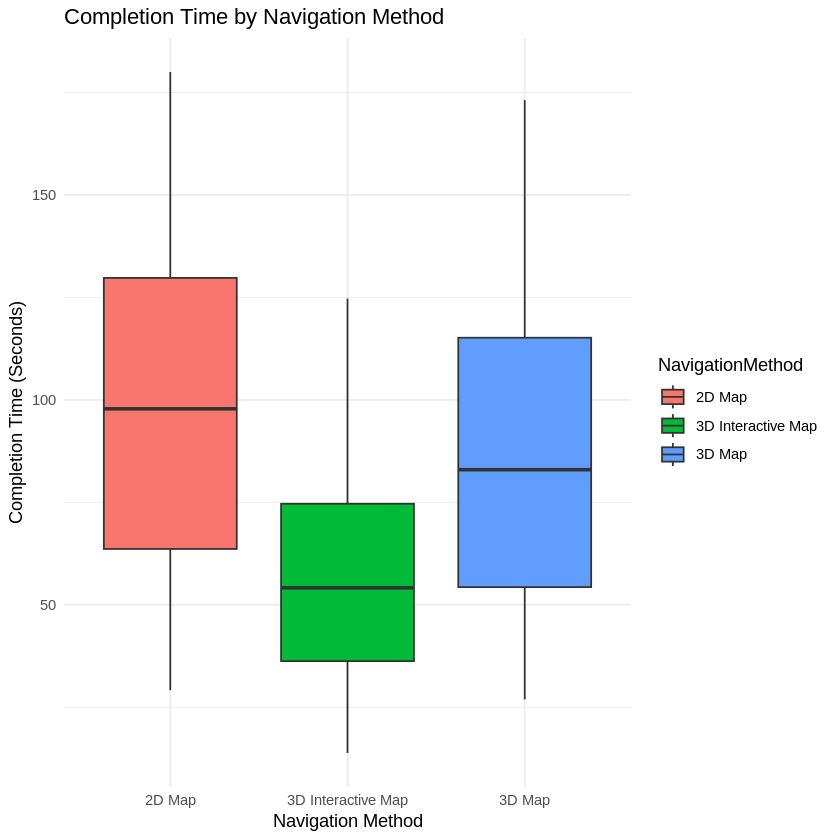

In [ ]:
all_method_data <- do.call(rbind, lapply(maps, function(map) {
  file_path <- output_files[[map]]

  if (file.exists(file_path)) {
    method_data <- read.csv(file_path) %>%
      mutate(
        NavigationMethod = map,
        TimeTakenSeconds = as.numeric(TimeTakenSeconds)
      )
    return(method_data)
  } else {
    return(NULL)
  }
}))


ggplot(all_method_data, aes(x = NavigationMethod, y = TimeTakenSeconds, fill = NavigationMethod)) +
  geom_boxplot() +
  labs(title = "Completion Time by Navigation Method",
       x = "Navigation Method",
       y = "Completion Time (Seconds)") +
  theme_minimal()

This script computes descriptive statistics for task completion times across different navigation methods (2D Map, 3D Interactive Map, and 3D Map). The script calculates the mean, median, standard deviation, and sample size for each method, providing a summary of the central tendency and variability in completion times.

In [ ]:
descriptive_stats <- all_method_data %>%
  group_by(NavigationMethod) %>%
  summarize(
    MeanTime = mean(TimeTakenSeconds, na.rm = TRUE),
    MedianTime = median(TimeTakenSeconds, na.rm = TRUE),
    StdDevTime = sd(TimeTakenSeconds, na.rm = TRUE),
    SampleSize = n()
  )

descriptive_stats

NavigationMethod,MeanTime,MedianTime,StdDevTime,SampleSize
<chr>,<dbl>,<dbl>,<dbl>,<int>
2D Map,101.11029,97.84,47.21098,70
3D Interactive Map,57.25286,54.15,28.02156,70
3D Map,86.77200,82.98,38.97063,70


These statistics highlight that the 3D Interactive Map has the lowest mean and median times, indicating it is the most efficient method. The 2D Map exhibits the highest variability, as reflected by its standard deviation.

The script aims to evaluate whether there are statistically significant differences in task completion times across the three navigation methods.
If the ANOVA test detects significant differences, a Tukey's post-hoc analysis is conducted to identify which pairs of navigation methods differ significantly.

In [ ]:
anova_data <- all_method_data %>%
  filter(!is.na(as.numeric(TimeTakenSeconds))) %>%
  mutate(TimeTakenSeconds = as.numeric(TimeTakenSeconds))

# Perform one-way ANOVA
anova_results <- aov(TimeTakenSeconds ~ NavigationMethod, data = anova_data)

summary(anova_results)

# Check if the ANOVA test is significant and perform post-hoc analysis
if (summary(anova_results)[[1]]$`Pr(>F)`[1] < 0.05) {
  posthoc_results <- TukeyHSD(anova_results)
  posthoc_results
} else {
  cat("No significant differences found in ANOVA. Post-hoc test not performed.")
}


                  Df Sum Sq Mean Sq F value   Pr(>F)    
NavigationMethod   2  70010   35005   23.17 8.32e-10 ***
Residuals        207 312763    1511                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = TimeTakenSeconds ~ NavigationMethod, data = anova_data)

$NavigationMethod
                               diff       lwr        upr     p adj
3D Interactive Map-2D Map -43.85743 -59.36803 -28.346829 0.0000000
3D Map-2D Map             -14.33829 -29.84889   1.172314 0.0766123
3D Map-3D Interactive Map  29.51914  14.00854  45.029743 0.0000347


**One-Way ANOVA Results:**

p-value = 3.36e-05
The ANOVA test shows a statistically significant difference in task completion times among the navigation methods (p < 0.05).

**Tukey's Post-Hoc Analysis:**

**3D Interactive Map vs. 2D Map:**
p-value = 0.0000256
The 3D Interactive Map is significantly faster than the 2D Map.

**3D Map vs. 2D Map:**
p-value = 0.2804
No significant difference between the 3D Map and the 2D Map.

**3D Map vs. 3D Interactive Map:**
p-value = 0.005953
The 3D Interactive Map is significantly faster than the 3D Map.

The ANOVA and post-hoc results confirm that the 3D Interactive Map is significantly faster than both the 2D Map and the 3D Map. However, there is no significant difference between the 2D Map and the 3D Map in terms of task completion times. This analysis supports the hypothesis that the 3D Interactive Map is the most efficient navigation method.

As shown before, the ANOVA test demonstrated a statistically significant difference in task completion times among the navigation methods we are going to implement the  Welch's t-tests to further comprove this.

This script performs Welch's t-tests to compare the task completion times between different navigation methods. The goal is to determine whether the differences in mean times are statistically significant.
Welch's t-test is chosen as it accounts for unequal variances and sample sizes between groups.

In [ ]:
group_counts <- all_method_data %>%
  group_by(NavigationMethod) %>%
  summarize(Count = n())

twoD_map_data <- all_method_data$TimeTakenSeconds[all_method_data$NavigationMethod == "2D Map"]
threeD_non_int_map_data <- all_method_data$TimeTakenSeconds[all_method_data$NavigationMethod == "3D Map"]
threeD_int_map_data <- all_method_data$TimeTakenSeconds[all_method_data$NavigationMethod == "3D Interactive Map"]

# Perform Welch's t-tests only if both groups have at least 2 observations
if (group_counts$Count[group_counts$NavigationMethod == "2D Map"] >= 2 &&
    group_counts$Count[group_counts$NavigationMethod == "3D Map"] >= 2) {
  t_test_2D_vs_3D <- t.test(
    twoD_map_data,
    threeD_non_int_map_data,
    var.equal = FALSE
  )
  cat("T-Test Results: 2D Map vs 3D Map\n")
  print(t_test_2D_vs_3D)
} else {
  cat("Not enough observations for 2D Map vs 3D Map t-test.\n")
}

if (group_counts$Count[group_counts$NavigationMethod == "2D Map"] >= 2 &&
    group_counts$Count[group_counts$NavigationMethod == "3D Interactive Map"] >= 2) {
  t_test_2D_vs_3D_interactive <- t.test(
    twoD_map_data,
    threeD_int_map_data,
    var.equal = FALSE
  )
  cat("\nT-Test Results: 2D Map vs 3D Interactive Map\n")
  print(t_test_2D_vs_3D_interactive)
} else {
  cat("Not enough observations for 2D Map vs 3D Interactive Map t-test.\n")
}

if (group_counts$Count[group_counts$NavigationMethod == "3D Map"] >= 2 &&
    group_counts$Count[group_counts$NavigationMethod == "3D Interactive Map"] >= 2) {
  t_test_3D_vs_3D_interactive <- t.test(
    threeD_non_int_map_data,
    threeD_int_map_data,
    var.equal = FALSE
  )
  cat("\nT-Test Results: 3D Map vs 3D Interactive Map\n")
  print(t_test_3D_vs_3D_interactive)
} else {
  cat("Not enough observations for 3D Map vs 3D Interactive Map t-test.\n")
}

T-Test Results: 2D Map vs 3D Map

	Welch Two Sample t-test

data:  twoD_map_data and threeD_non_int_map_data
t = 1.9596, df = 133.22, p-value = 0.05213
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1340331 28.8106045
sample estimates:
mean of x mean of y 
 101.1103   86.7720 


T-Test Results: 2D Map vs 3D Interactive Map

	Welch Two Sample t-test

data:  twoD_map_data and threeD_int_map_data
t = 6.6837, df = 112.25, p-value = 9.412e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 30.85621 56.85865
sample estimates:
mean of x mean of y 
101.11029  57.25286 


T-Test Results: 3D Map vs 3D Interactive Map

	Welch Two Sample t-test

data:  threeD_non_int_map_data and threeD_int_map_data
t = 5.1454, df = 125.3, p-value = 1.002e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 18.16518 40.87310
sample estimates:
mean of x mean 

**2D Map vs. 3D Map:**

p-value = 0.1736
No statistically significant difference in completion times (p > 0.05).

**2D Map vs. 3D Interactive Map:**

p-value = 1.821e-05
Statistically significant difference in completion times (p < 0.05).

**3D Map vs. 3D Interactive Map:**

p-value = 0.0006113
Statistically significant difference in completion times (p < 0.05).

The results indicate that the 3D Interactive Map is the fastest navigation method, with statistically significant differences compared to both the 2D Map and the 3D Map. However, there is no significant difference between the 2D Map and the 3D Map.

# PRE TASK ANALYSIS

This section represents the demographics of our user group.

In [ ]:
pre_test_data_eng <- read.csv("sample_data/Pre-test.csv", stringsAsFactors = FALSE)
pre_test_data_pt <- read.csv("sample_data/Pré-teste.csv", stringsAsFactors = FALSE)

colnames(pre_test_data_eng) <- c(
  "Timestamp",
  "UserID",
  "Consent",
  "Age",
  "Gender",
  "Education",
  "DomHand",
  "ExperienceVR",
  "MotionSickness",
  "VisualImpairments",
  "DiscomfortDesc",
  "Confidence",
  "VisitMuseums",
  "Artist"
)

pre_test_data_eng <- pre_test_data_eng %>%
  select(-Consent)

colnames(pre_test_data_pt) <- c(
  "Timestamp",
  "UserID",
  "Age",
  "Gender",
  "Education",
  "DomHand",
  "ExperienceVR",
  "MotionSickness",
  "VisualImpairments",
  "DiscomfortDesc",
  "Confidence",
  "VisitMuseums",
  "Artist"
)


Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'sample_data/Pre-test.csv'”


In [ ]:
pre_test_data_pt <- pre_test_data_pt %>%
  mutate(
    Gender = case_when(
      Gender == "Feminino" ~ "Female",
      Gender == "Masculino" ~ "Male",
      Gender == "Prefiro não dizer/outro" ~ "Prefer not to say",
      TRUE ~ NA_character_
    ),
    Education = case_when(
      Education == "Nenhuma escolaridade completa" ~ "No schooling completed",
      Education == "Ensino Básico" ~ "Primary Education completed",
      Education == "Ensino Secundário" ~ "High School completed",
      Education == "Formação comercial/técnica/profissional" ~ "Trade/technical/vocational training completed",
      Education == "Ensino Superior - Licenciatura" ~ "Bachelor's degree obtained",
      Education == "Ensino Superior - Mestrado" ~ "Master's degree obtained",
      Education == "Grau Profissional" ~ "Professional degree obtained",
      Education == "Ensino Superior - Doutoramento" ~ "Doctorate/PhD degree obtained",
      TRUE ~ NA_character_
    ),
    DomHand = case_when(
      DomHand == "A mão direita." ~ "I'm right-handed.",
      DomHand == "A mão esquerda." ~ "I'm left-handed.",
      DomHand == "Ambas (ambidestro).t" ~ "I'm ambidextrous.",
      TRUE ~ NA_character_
    ),
     ExperienceVR = case_when(
      ExperienceVR == "Nunca utilizei RV." ~ "I have never used VR.",
      ExperienceVR == "Tentei RV uma vez." ~ "I have tried VR once.",
      ExperienceVR == "Já utilizei RV umas vezes." ~ "I have tried VR a few times.",
      ExperienceVR == "Já utilizei RV várias vezes e sou experiente." ~"I have used VR many times and am experienced in it.",
      TRUE ~ NA_character_
    ),
    MotionSickness = case_when(
      MotionSickness == "Sim." ~ "Yes.",
      MotionSickness == "Não." ~ "No.",
      MotionSickness == "Não sei (não tenho experiẽncia que chegue em RV para saber)." ~"Not sure (I haven't used VR enough to know).",
      TRUE ~ NA_character_
    )
  )

pre_test_data <- bind_rows(pre_test_data_eng, pre_test_data_pt)

pre_test_data

Timestamp,UserID,Age,Gender,Education,DomHand,ExperienceVR,MotionSickness,VisualImpairments,DiscomfortDesc,Confidence,VisitMuseums,Artist
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>
20/12/2024 10:17:33,1,15-24,Female,Bachelor's degree obtained,I'm right-handed.,I have tried VR a few times.,"Yes, occasonally.",No,no,5,A few times a year.,4
20/12/2024 10:45:48,2,65+,Male,Doctorate/PhD degree obtained,I'm right-handed.,I have used VR many times and am experienced in it.,"No, never.",no,no,7,I regularly visit museums.,5
20/12/2024 19:59:35,3,15-24,Male,Bachelor's degree obtained,I'm right-handed.,I have tried VR once.,Not sure (I haven't used VR enough to know).,Miopia,No.,4,At least once a year.,2
2024/12/22 14:38:04,4,45-54,Male,High School completed,I'm right-handed.,I have never used VR.,Not sure (I haven't used VR enough to know).,nao,Não,6,Já foi a um museu uma vez ou outra.,1
2024/12/22 14:49:27,5,45-54,Female,High School completed,I'm right-handed.,I have never used VR.,Not sure (I haven't used VR enough to know).,,Não,2,Já foi a um museu uma vez ou outra.,1
2025/01/04 13:41:18,6,35-44,Male,Bachelor's degree obtained,I'm right-handed.,I have never used VR.,Not sure (I haven't used VR enough to know).,,Não,5,Pelo menos uma por ano.,3
2025/01/04 16:11:06,7,35-44,Female,Bachelor's degree obtained,I'm right-handed.,I have never used VR.,Not sure (I haven't used VR enough to know).,,Não,2,Pelo menos uma por ano.,2
2025/01/04 16:24:47,8,15-24,Male,Primary Education completed,I'm right-handed.,I have tried VR once.,Not sure (I haven't used VR enough to know).,,Não,6,Já foi a um museu uma vez ou outra.,1
2025/01/04 16:34:45,9,15-24,Male,High School completed,I'm right-handed.,I have used VR many times and am experienced in it.,No.,,Não,6,Já foi a um museu uma vez ou outra.,1


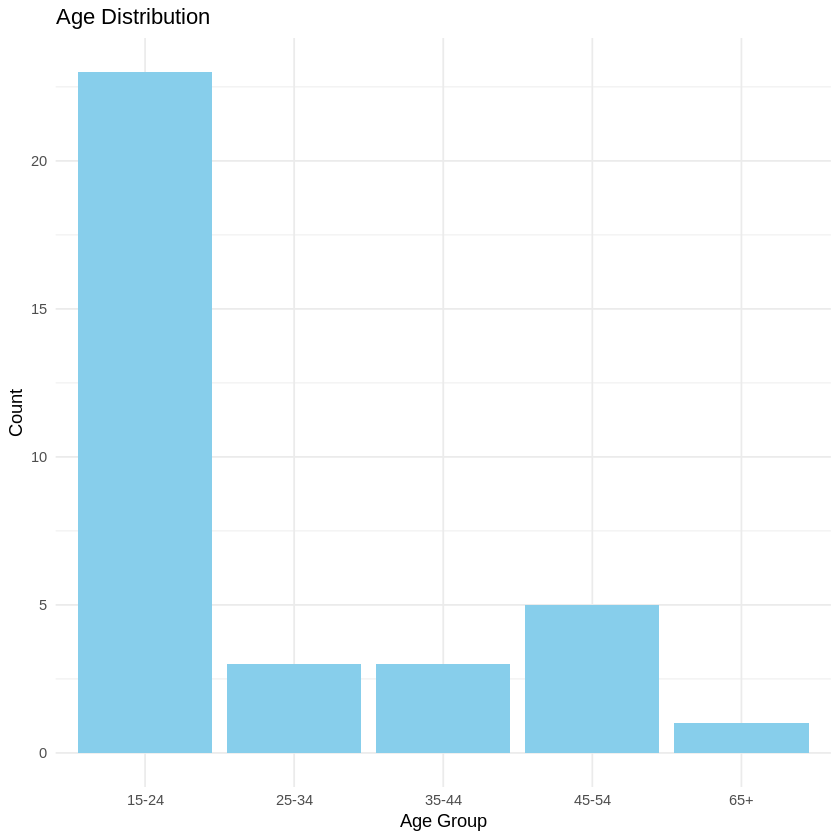

In [ ]:
ggplot(pre_test_data, aes(x = Age)) +
  geom_bar(fill = "skyblue") +
  labs(title = "Age Distribution", x = "Age Group", y = "Count") +
  theme_minimal()

Number of Men: 21 
Number of Women: 14 


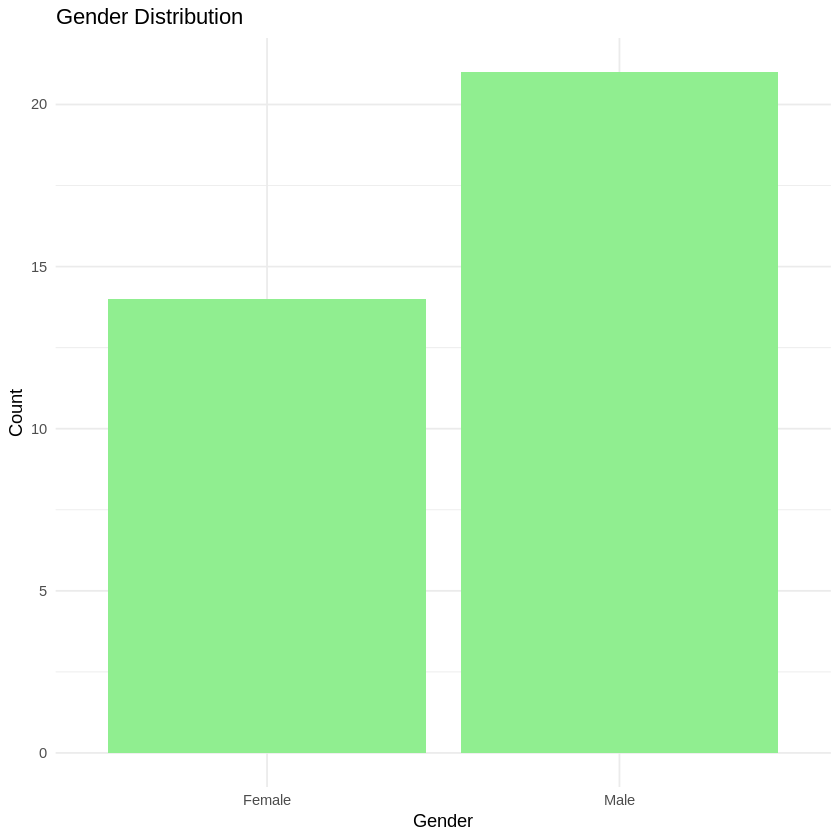

In [ ]:
# Gender distribution
ggplot(pre_test_data, aes(x = Gender)) +
  geom_bar(fill = "lightgreen") +
  labs(title = "Gender Distribution", x = "Gender", y = "Count") +
  theme_minimal()

# Count the number of men and women
male_count <- nrow(pre_test_data[pre_test_data$Gender == "Male", ])
female_count <- nrow(pre_test_data[pre_test_data$Gender == "Female", ])

# Print the counts
cat("Number of Men:", male_count, "\n")
cat("Number of Women:", female_count, "\n")


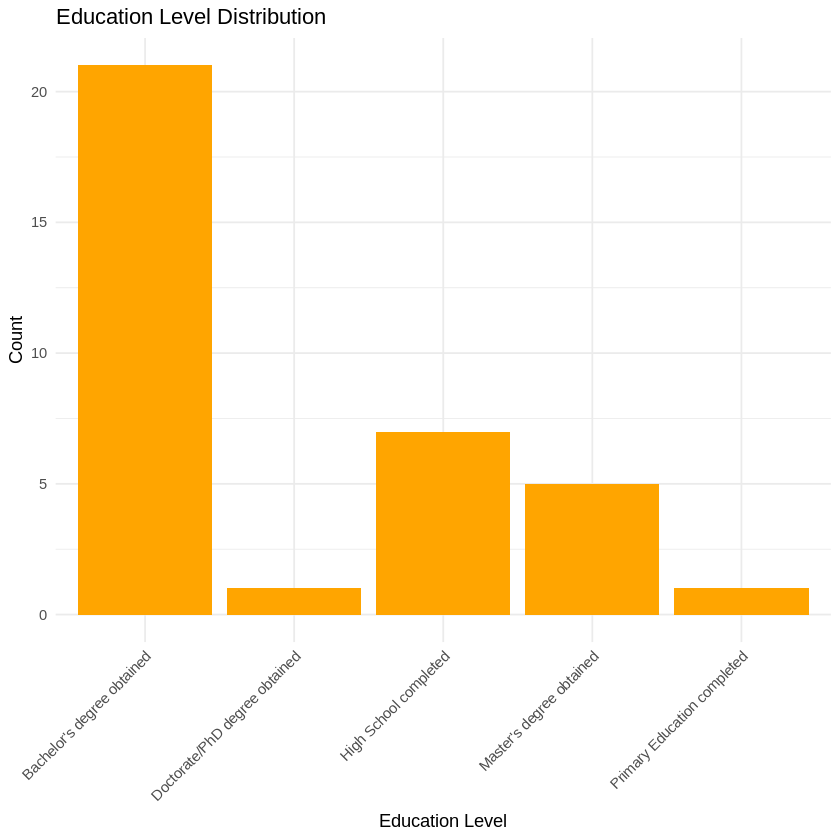

In [ ]:
# Education level
ggplot(pre_test_data, aes(x = Education)) +
  geom_bar(fill = "orange") +
  labs(title = "Education Level Distribution", x = "Education Level", y = "Count") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


I have never used VR:  9 
I have tried VR once:  5 
I have tried VR a few times:  12 
I have used VR many times and am experienced in it:  9 


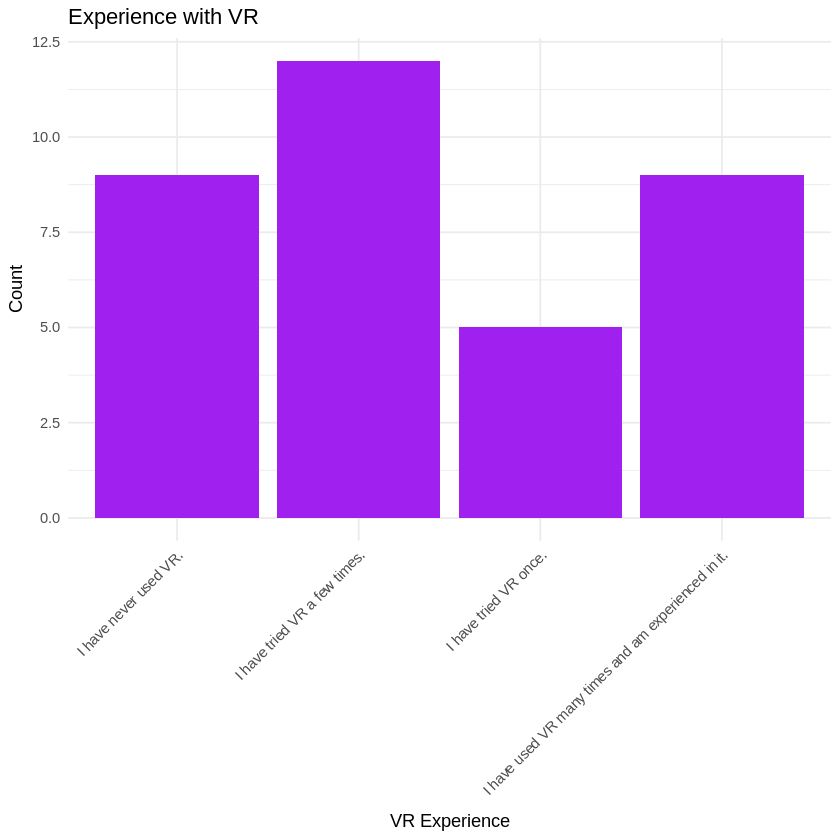

In [ ]:
# Experience with VR
ggplot(pre_test_data, aes(x = ExperienceVR)) +
  geom_bar(fill = "purple") +
  labs(title = "Experience with VR", x = "VR Experience", y = "Count") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

cat("I have never used VR: ", sum(pre_test_data$ExperienceVR == "I have never used VR."), "\n")
cat("I have tried VR once: ", sum(pre_test_data$ExperienceVR == "I have tried VR once."), "\n")
cat("I have tried VR a few times: ", sum(pre_test_data$ExperienceVR == "I have tried VR a few times."), "\n")
cat("I have used VR many times and am experienced in it: ", sum(pre_test_data$ExperienceVR == "I have used VR many times and am experienced in it."), "\n")


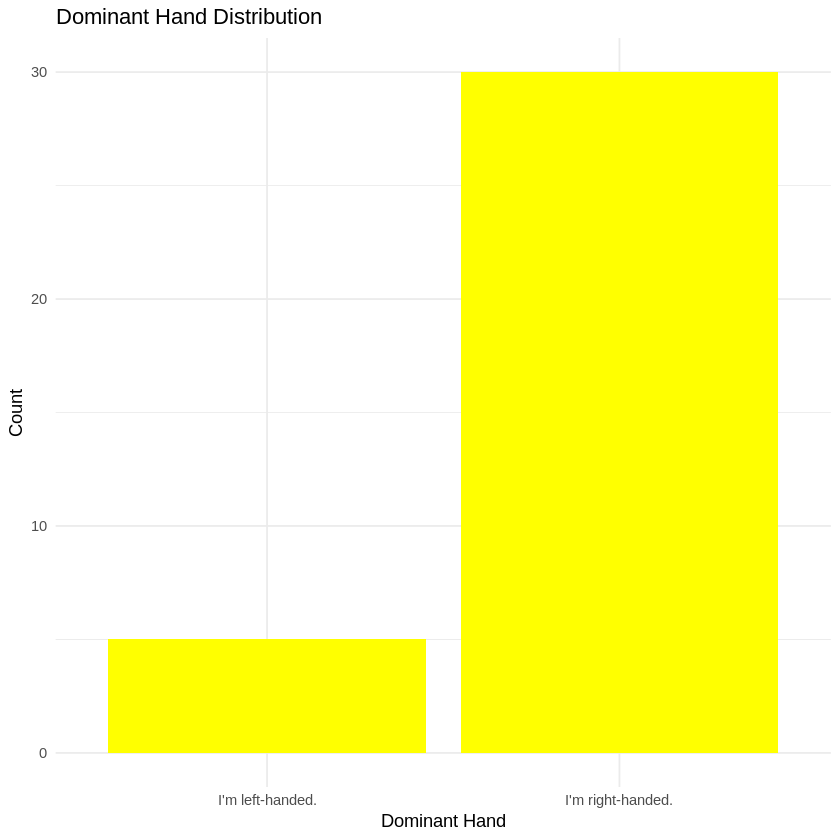

In [ ]:
# Dominant hand distribution
ggplot(pre_test_data, aes(x = DomHand)) +
  geom_bar(fill = "yellow") +
  labs(title = "Dominant Hand Distribution", x = "Dominant Hand", y = "Count") +
  theme_minimal()


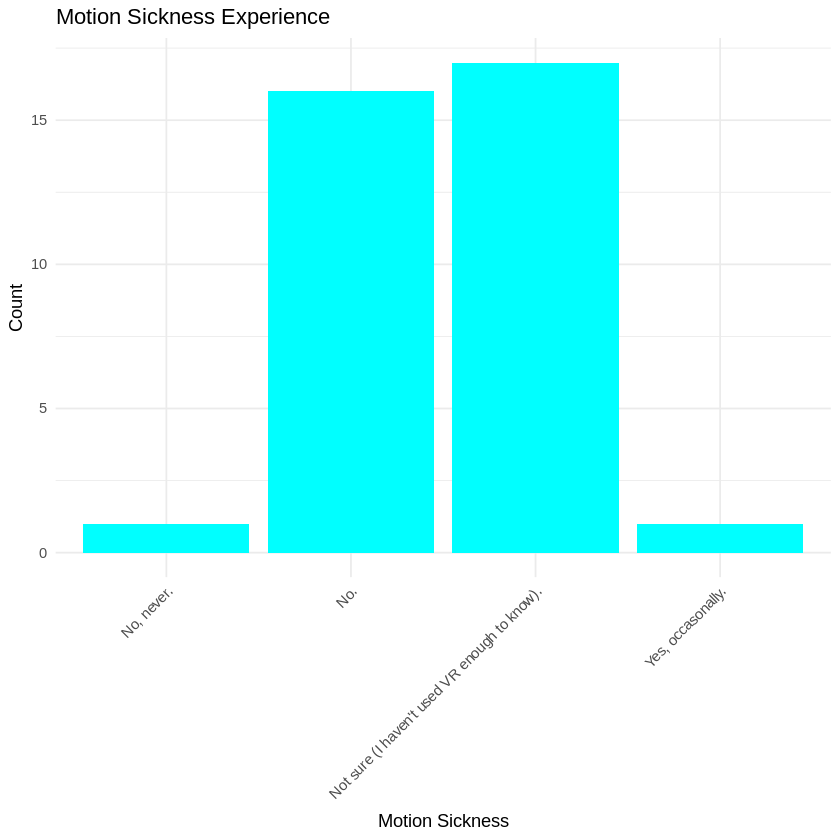

In [ ]:
# Motion sickness experience
ggplot(pre_test_data, aes(x = MotionSickness)) +
  geom_bar(fill = "cyan") +
  labs(title = "Motion Sickness Experience", x = "Motion Sickness", y = "Count") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# POST TASK ANALYSIS

This section aims to analyze user's responses to each post-task questionnaire.

In [ ]:
post_task_data_eng <- read.csv("sample_data/Post-Task.csv", stringsAsFactors = FALSE)
post_task_data_pt <- read.csv("sample_data/Pós-Tarefa.csv", stringsAsFactors = FALSE)

colnames(post_task_data_eng) <- c(
  "Timestamp",
  "UserID",
  "Method",
  "Complexity",
  "EaseOfUse",
  "LearnQuickly",
  "Confidence",
  "LearningNeed",
  "MapUse",
  "Comfort",
  "MotionSickness",
  "DiscomfortDesc",
  "Familiarity",
  "EaseOfFinding"
)

colnames(post_task_data_pt) <- c(
  "Timestamp",
  "UserID",
  "Method",
  "Complexity",
  "EaseOfUse",
  "LearnQuickly",
  "Confidence",
  "LearningNeed",
  "MapUse",
  "Comfort",
  "MotionSickness",
  "DiscomfortDesc",
  "Familiarity",
  "EaseOfFinding"
)

post_task_data_pt <- post_task_data_pt %>%
  mutate(
    Method = case_when(
      Method == "Mapa 3D interativo." ~ "Interactive 3D map",
      Method == "Mapa 2D" ~ "Non-interactive 2D map",
      Method == "Mapa 3D não interativo." ~ "Non-interactive 3D map",
      TRUE ~ NA_character_
    ),
    MotionSickness = case_when(
      MotionSickness == "Não" ~ "No",
      MotionSickness == "Sim" ~ "Yes",
      TRUE ~ NA_character_
    ),
    DiscomfortDesc = case_when(
      DiscomfortDesc == "Não" ~ "No",
      DiscomfortDesc == "Sim" ~ "Yes",
      TRUE ~ NA_character_
    ),
    Familiarity = case_when(
      Familiarity == "Não de todo" ~ "Not at all",
      Familiarity == "Vagamente" ~ "Vaguely",
      Familiarity == "Muito" ~ "Very",
      TRUE ~ NA_character_
    )
  )

post_task_data <- bind_rows(post_task_data_eng, post_task_data_pt)

post_task_data

Timestamp,UserID,Method,Complexity,EaseOfUse,LearnQuickly,Confidence,LearningNeed,MapUse,Comfort,MotionSickness,DiscomfortDesc,Familiarity,EaseOfFinding
<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>
20/12/2024 10:21:57,1,Interactive 3D map,2,4,3,4,3,5,6,No,NA,Not at all,7
20/12/2024 10:23:44,1,Non-interactive 2D map,4,2,2,3,4,3,5,No,NA,Not at all,4
20/12/2024 10:25:37,1,Non-interactive 3D map,3,3,4,4,2,3,5,No,NA,Very,4
20/12/2024 10:55:50,2,Interactive 3D map,2,3,2,5,1,5,5,No,NA,Vaguely,6
20/12/2024 10:59:31,2,Non-interactive 3D map,3,2,3,3,1,3,4,No,NA,Very,2
20/12/2024 11:05:08,2,Non-interactive 2D map,4,4,3,3,1,4,5,No,NA,Very,3
20/12/2024 20:07:51,3,Non-interactive 2D map,1,4,5,4,1,7,6,No,NA,Vaguely,7
20/12/2024 20:09:51,3,Non-interactive 3D map,1,4,5,4,1,7,6,No,NA,Not at all,7
20/12/2024 20:11:00,3,Interactive 3D map,1,5,5,5,1,7,7,No,NA,Not at all,7


The goal of this script is to compute a personalized SUS-like score for each navigation method based on the collected questionnaire data.

In [ ]:
# Replace non-numeric values in specific columns with numeric equivalents
post_task_data <- post_task_data %>%
  mutate(
    MotionSickness = case_when(
      MotionSickness == "No" ~ 1,
      MotionSickness == "Yes" ~ 5,
      TRUE ~ NA_real_
    ),
    DiscomfortDesc = case_when(
      DiscomfortDesc == "No" ~ 1,
      DiscomfortDesc == "Yes" ~ 5,
      TRUE ~ NA_real_
    ),
    Familiarity = case_when(
      Familiarity == "Not at all" ~ 1,
      Familiarity == "Vaguely" ~ 3,
      Familiarity == "Very" ~ 5,
      TRUE ~ NA_real_
    )
  )

post_task_data <- post_task_data %>%
  mutate(
    Complexity_Adjusted = Complexity - 1,
    EaseOfUse_Adjusted = EaseOfUse - 1,
    LearnQuickly_Adjusted = LearnQuickly - 1,
    Confidence_Adjusted = Confidence - 1,
    LearningNeed_Adjusted = LearningNeed - 1,
    MapUse_Adjusted = MapUse - 1,
    Comfort_Adjusted = Comfort - 1,
    Familiarity_Adjusted = case_when(
      Familiarity == "Not at all" ~ 1,
      Familiarity == "Vaguely" ~ 3,
      Familiarity == "Very" ~ 5,
      TRUE ~ NA_real_
    ),
    EaseOfFinding_Adjusted = EaseOfFinding - 1
  )

post_task_data <- post_task_data %>%
  rowwise() %>%
  mutate(
    SUS_RawScore = sum(
      Complexity_Adjusted,
      EaseOfUse_Adjusted,
      LearnQuickly_Adjusted,
      Confidence_Adjusted,
      LearningNeed_Adjusted,
      MapUse_Adjusted,
      Comfort_Adjusted,
      Familiarity_Adjusted,
      EaseOfFinding_Adjusted,
      na.rm = TRUE
    ),
    SUS_Score = SUS_RawScore * 2.5  # Convert to a SUS-like score
  ) %>%
  ungroup()

sus_summary <- post_task_data %>%
  group_by(Method) %>%
  summarize(
    Mean_SUS_Score = mean(SUS_Score, na.rm = TRUE),
    Median_SUS_Score = median(SUS_Score, na.rm = TRUE),
    StdDev_SUS_Score = sd(SUS_Score, na.rm = TRUE),
    SampleSize = n()
  )

sus_summary

Method,Mean_SUS_Score,Median_SUS_Score,StdDev_SUS_Score,SampleSize
<chr>,<dbl>,<dbl>,<dbl>,<int>
Interactive 3D map,70.42857,72.5,5.268026,35
Non-interactive 2D map,56.10294,57.5,12.600974,34
Non-interactive 3D map,61.71429,62.5,9.940474,35


**Interactive 3D Map:**

Achieved the highest mean SUS score, indicating the highest overall usability perception.

**Non-Interactive 2D Map:**

Recorded the lowest mean SUS score, showing it is perceived as less usable compared to other methods.

**Non-Interactive 3D Map:**

Performed moderately, with scores between the 2D map and the Interactive 3D map.

The purpose of this script is to perform pairwise Welch's t-tests to assess the statistical significance of differences in System Usability Scale (SUS) scores between navigation methods in the study.

In [ ]:
interactive_3D_map_scores <- post_task_data$SUS_Score[post_task_data$Method == "Interactive 3D map"]
non_interactive_2D_map_scores <- post_task_data$SUS_Score[post_task_data$Method == "Non-interactive 2D map"]
non_interactive_3D_map_scores <- post_task_data$SUS_Score[post_task_data$Method == "Non-interactive 3D map"]

# Perform Welch's t-tests between navigation methods
t_test_interactive_vs_2D <- t.test(
  interactive_3D_map_scores,
  non_interactive_2D_map_scores,
  var.equal = FALSE
)
cat("T-Test Results: Interactive 3D Map vs Non-Interactive 2D Map\n")
print(t_test_interactive_vs_2D)

t_test_interactive_vs_3D <- t.test(
  interactive_3D_map_scores,
  non_interactive_3D_map_scores,
  var.equal = FALSE
)
cat("\nT-Test Results: Interactive 3D Map vs Non-Interactive 3D Map\n")
print(t_test_interactive_vs_3D)

t_test_2D_vs_3D <- t.test(
  non_interactive_2D_map_scores,
  non_interactive_3D_map_scores,
  var.equal = FALSE
)
cat("\nT-Test Results: Non-Interactive 2D Map vs Non-Interactive 3D Map\n")
print(t_test_2D_vs_3D)


T-Test Results: Interactive 3D Map vs Non-Interactive 2D Map

	Welch Two Sample t-test

data:  interactive_3D_map_scores and non_interactive_2D_map_scores
t = 6.1291, df = 43.928, p-value = 2.193e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  9.614859 19.036401
sample estimates:
mean of x mean of y 
 70.42857  56.10294 


T-Test Results: Interactive 3D Map vs Non-Interactive 3D Map

	Welch Two Sample t-test

data:  interactive_3D_map_scores and non_interactive_3D_map_scores
t = 4.5826, df = 51.702, p-value = 2.936e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  4.897889 12.530683
sample estimates:
mean of x mean of y 
 70.42857  61.71429 


T-Test Results: Non-Interactive 2D Map vs Non-Interactive 3D Map

	Welch Two Sample t-test

data:  non_interactive_2D_map_scores and non_interactive_3D_map_scores
t = -2.0499, df = 62.714, p-value = 0.04456
alternative hypothesis: true 

**Interactive 3D Map vs. Non-Interactive 2D Map:**

t-statistic: 6.1291

p-value: 2.193e-07 (statistically significant at p < 0.05).

The Interactive 3D Map had significantly higher SUS scores than the Non-Interactive 2D Map, suggesting it was perceived as more usable.

**Interactive 3D Map vs. Non-Interactive 3D Map:**

t-statistic: 4.5826

p-value: 2.936e-05 (statistically significant at p < 0.05).

The Interactive 3D Map had significantly higher SUS scores than the Non-Interactive 3D Map, indicating higher perceived usability.

**Non-Interactive 2D Map vs. Non-Interactive 3D Map:**

t-statistic: -2.0499

p-value: 0.04456 (statistically significant at p < 0.05).

The Non-Interactive 3D Map had significantly higher SUS scores than the Non-Interactive 2D Map, suggesting it was considered more usable.

**The results highlight that:**

*   The Interactive 3D Map was the most favorably rated navigation method in terms of usability.
*   The Non-Interactive 3D Map was rated more usable than the Non-Interactive 2D Map, but less usable than the Interactive 3D Map.

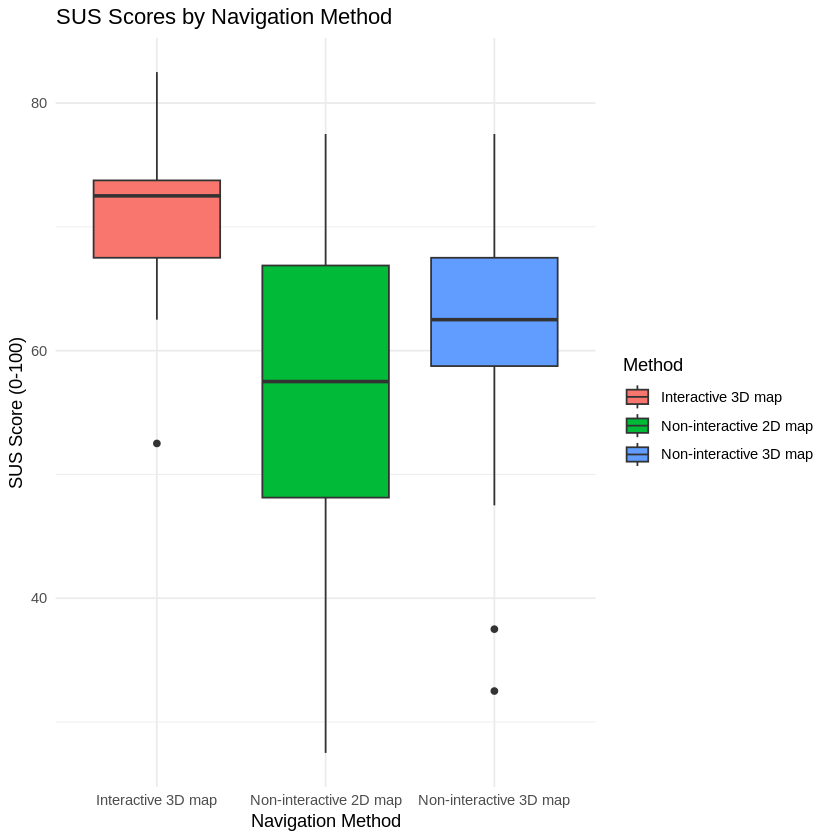

In [ ]:
ggplot(post_task_data, aes(x = Method, y = SUS_Score, fill = Method)) +
  geom_boxplot() +
  labs(
    title = "SUS Scores by Navigation Method",
    x = "Navigation Method",
    y = "SUS Score (0-100)"
  ) +
  theme_minimal()


The goal of this script is to analyze participant feedback on the Complexity and Ease of Use of the navigation methods employed in the VR environment. It aims to determine how participants perceived each method and whether one method stands out as being simpler or more intuitive.

In [ ]:
complexity_ease_summary <- post_task_data %>%
  group_by(Method) %>%
  summarize(
    Mean_Complexity = mean(Complexity, na.rm = TRUE),
    Median_Complexity = median(Complexity, na.rm = TRUE),
    StdDev_Complexity = sd(Complexity, na.rm = TRUE),
    Mean_EaseOfUse = mean(EaseOfUse, na.rm = TRUE),
    Median_EaseOfUse = median(EaseOfUse, na.rm = TRUE),
    StdDev_EaseOfUse = sd(EaseOfUse, na.rm = TRUE),
    SampleSize = n()
  )

complexity_ease_summary

Method,Mean_Complexity,Median_Complexity,StdDev_Complexity,Mean_EaseOfUse,Median_EaseOfUse,StdDev_EaseOfUse,SampleSize
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Interactive 3D map,1.200000,1,0.4727890,4.571429,5,0.8147794,35
Non-interactive 2D map,1.823529,2,0.9683034,3.823529,4,0.9035482,34
Non-interactive 3D map,1.485714,1,0.7017385,4.000000,4,0.8043997,35


**Interactive 3D Map:**

Rated as the least complex method.
Achieved the highest ease-of-use score.

**Non-Interactive 2D Map:**

Perceived as the most complex method.
Scored the lowest on ease-of-use.

**Non-Interactive 3D Map:**

Scored moderately on both complexity and ease-of-use.

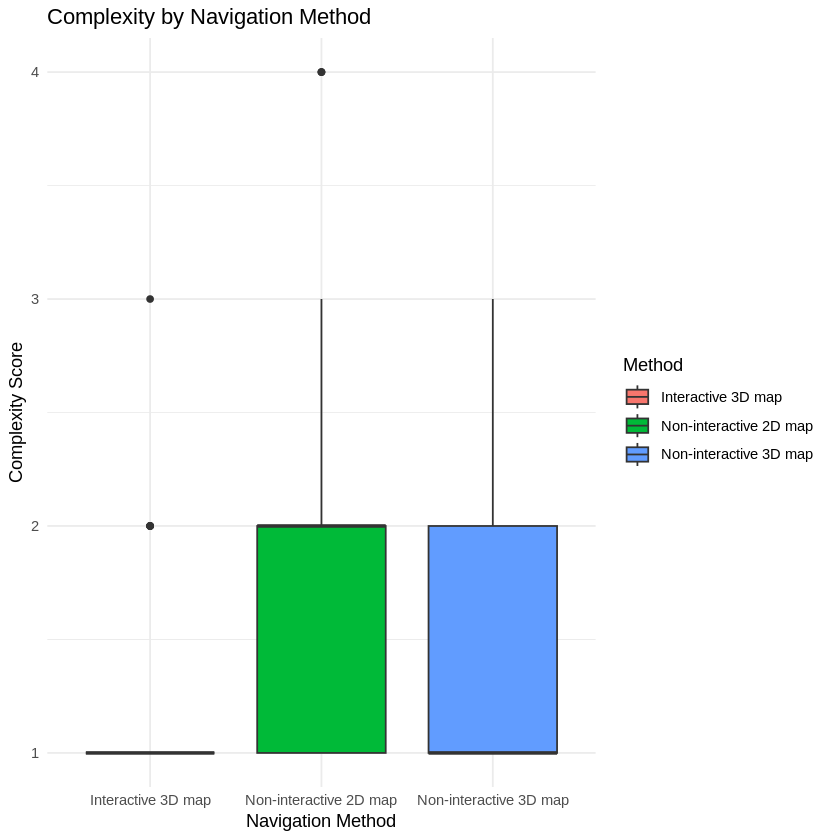

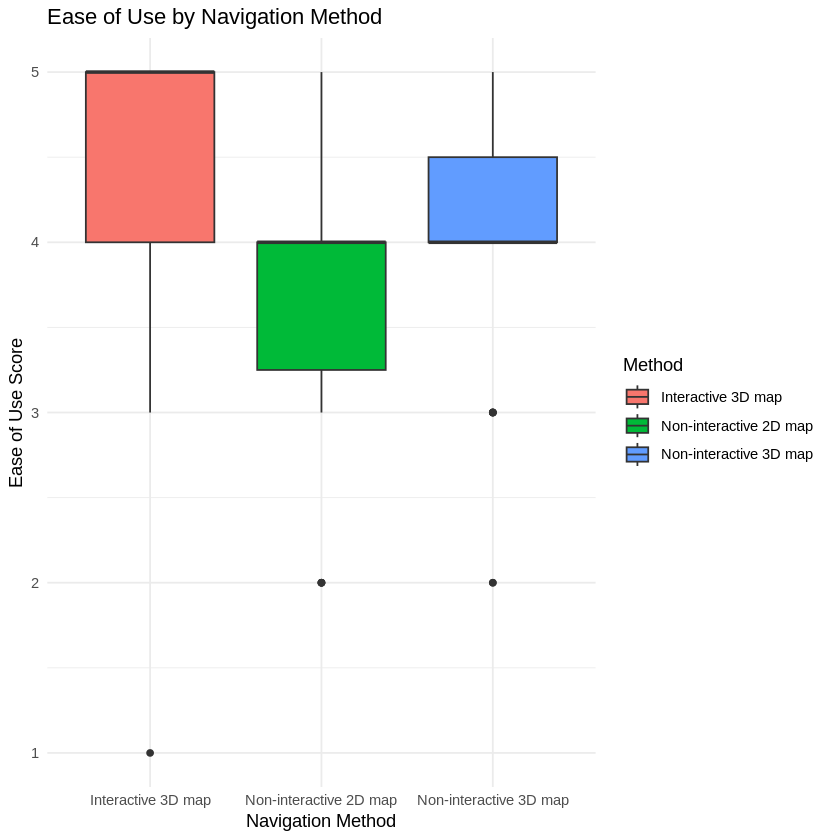

In [ ]:
# Complexity Boxplot
ggplot(post_task_data, aes(x = Method, y = Complexity, fill = Method)) +
  geom_boxplot() +
  labs(title = "Complexity by Navigation Method",
       x = "Navigation Method",
       y = "Complexity Score") +
  theme_minimal()

# Ease of Use Boxplot
ggplot(post_task_data, aes(x = Method, y = EaseOfUse, fill = Method)) +
  geom_boxplot() +
  labs(title = "Ease of Use by Navigation Method",
       x = "Navigation Method",
       y = "Ease of Use Score") +
  theme_minimal()


# POST TEST ANALYSIS

This section is going to evaluate the user's responses to the final post-test questionnaire.

In [ ]:
post_test_data_eng <- read.csv("sample_data/Post-Test.csv", stringsAsFactors = FALSE)
post_test_data_pt <- read.csv("sample_data/Pós-Teste.csv", stringsAsFactors = FALSE)

colnames(post_test_data_eng) <- c(
  "Timestamp",
  "ParticipantID",
  "MostEffectiveMap",
  "LeastEffectiveMap",
  "AdditionalComments"
)

colnames(post_test_data_pt) <- c(
  "Timestamp",
  "ParticipantID",
  "MostEffectiveMap",
  "LeastEffectiveMap",
  "AdditionalComments"
)

post_test_data_pt <- post_test_data_pt %>%
  mutate(
    MostEffectiveMap = case_when(
      MostEffectiveMap == "Mapa interativo 3D" ~ "Interactive 3D/WiM map",
      MostEffectiveMap == "Mapa 2D" ~ "2D map",
      MostEffectiveMap == "Mapa não interativo 3D" ~ "Non-interactive 3D/WiM map",
      TRUE ~ NA_character_
    ),
    LeastEffectiveMap = case_when(
      LeastEffectiveMap == "Mapa 3D interativo" ~ "Interactive 3D/WiM map	",
      LeastEffectiveMap == "Mapa 2D" ~ "2D map",
      LeastEffectiveMap == "Mapa 3D não interativo" ~ "Non-interactive 3D/WiM map",
      TRUE ~ NA_character_
    )
  )

post_test_data <- bind_rows(post_test_data_eng, post_test_data_pt)

# post_test_data

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'sample_data/Post-Test.csv'”


This next tests revises the answers to the question "Which map did you find the most effective to navigate the virtual museum?" on the post-test questionnaire.

In [ ]:
# Group data by MostEffectiveMap and count occurrences
most_effective_counts <- post_test_data %>%
  group_by(MostEffectiveMap) %>%
  summarize(Count = n()) %>%
  arrange(desc(Count))

# Group data by LeastEffectiveMap and count occurrences
least_effective_counts <- post_test_data %>%
  group_by(LeastEffectiveMap) %>%
  summarize(Count = n()) %>%
  arrange(desc(Count))

cat("Most Effective Maps:\n")
cat(most_effective_counts$MostEffectiveMap[1], sep = "\n")

cat("\nLeast Effective Maps:\n")
cat(least_effective_counts$LeastEffectiveMap[1], sep = "\n")

most_effective_counts

Most Effective Maps:
Interactive 3D/WiM map

Least Effective Maps:
2D map


MostEffectiveMap,Count
<chr>,<int>
Interactive 3D/WiM map,32
Non-interactive 3D/WiM map,2
2D map,1


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”


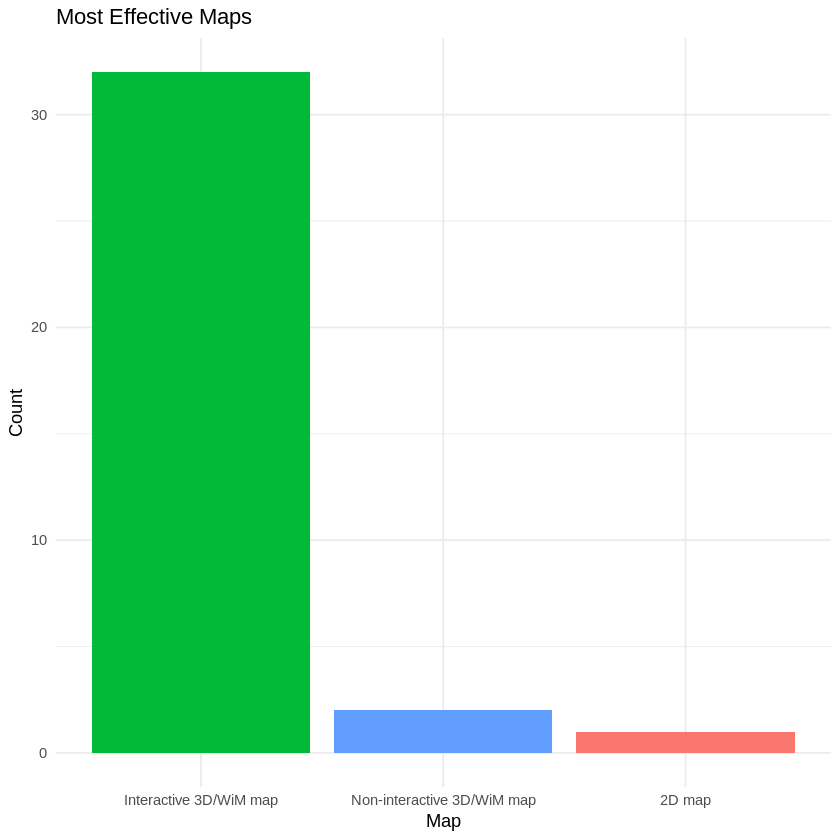

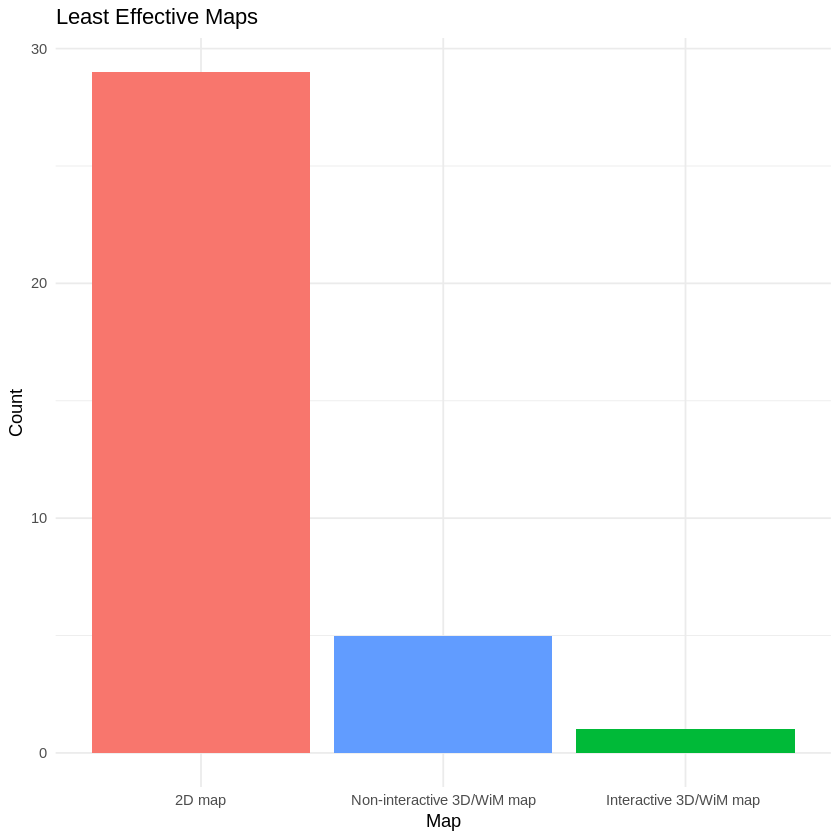

In [ ]:
ggplot(most_effective_counts, aes(x = reorder(MostEffectiveMap, -Count), y = Count, fill = MostEffectiveMap)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Most Effective Maps",
    x = "Map",
    y = "Count"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

ggplot(least_effective_counts, aes(x = reorder(LeastEffectiveMap, -Count), y = Count, fill = LeastEffectiveMap)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Least Effective Maps",
    x = "Map",
    y = "Count"
  ) +
  theme_minimal() +
  theme(legend.position = "none")


The analysis of cybersickness in our study was not conducted due to the limited occurrence of this phenomenon among participants. Out of the 35 users, only 2 reported experiencing cybersickness, which was attributed to the VR equipment itself rather than the navigation methods or the prototype implemented in our project. Consequently, the impact of cybersickness on the evaluation of navigation techniques was deemed negligible.